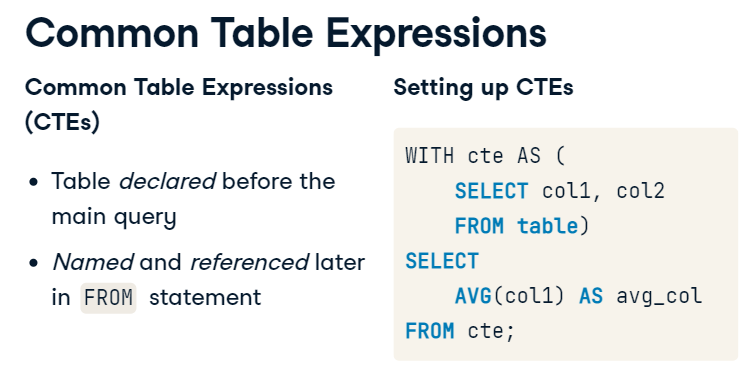
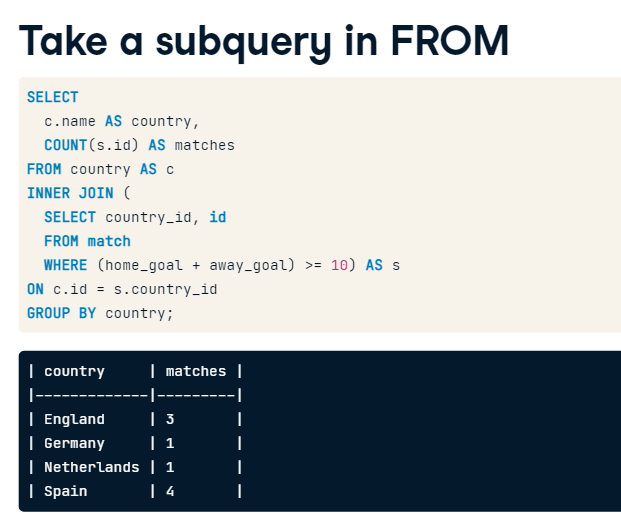
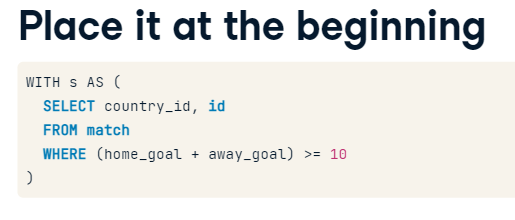
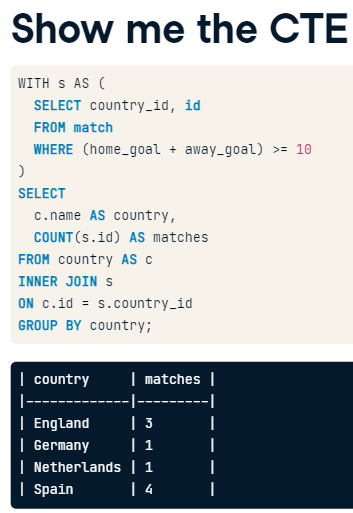
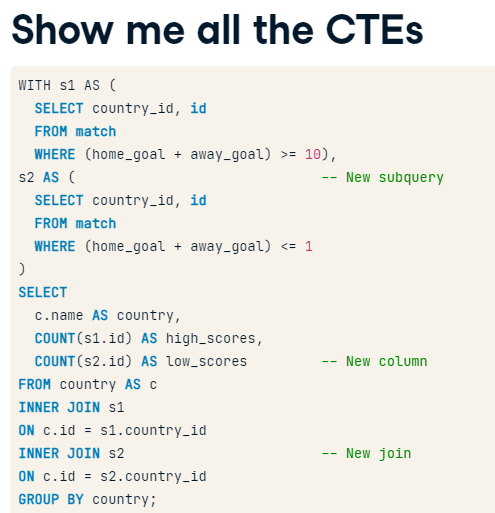
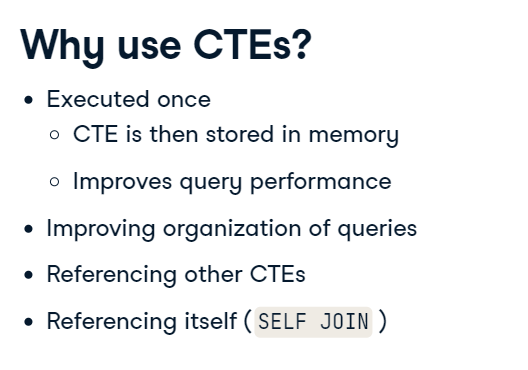
#### Clean up with CTEs
The query in that exercise utilized a subquery in the FROM statement in order to filter the matches before counting them in the main query. Below is the query you created:
```sql
SELECT
  c.name AS country,
  COUNT(sub.id) AS matches
FROM country AS c
INNER JOIN (
  SELECT country_id, id 
  FROM match
  WHERE (home_goal + away_goal) >= 10) AS sub
ON c.id = sub.country_id
GROUP BY country;
```
You can list one (or more) subqueries as common table expressions (CTEs) by declaring them ahead of your main query, which is an excellent tool for organizing information and placing it in a logical order.

In this exercise, let's rewrite a similar query using a CTE.

- Complete the syntax to declare your CTE.
- Select the country_id and match id from the match table in your CTE.
- Left join the CTE to the league table using country_id.


```sql
-- Set up your CTE
WITH match_list AS (
    SELECT 
  		country_id, 
  		id
    FROM match
    WHERE (home_goal + away_goal) >= 10)
-- Select league and count of matches from the CTE
SELECT
    l.name AS league,
    COUNT(match_list.id) AS matches
FROM league AS l
-- Join the CTE to the league table
LEFT JOIN match_list 
ON l.id = match_list.country_id
GROUP BY l.name;
```
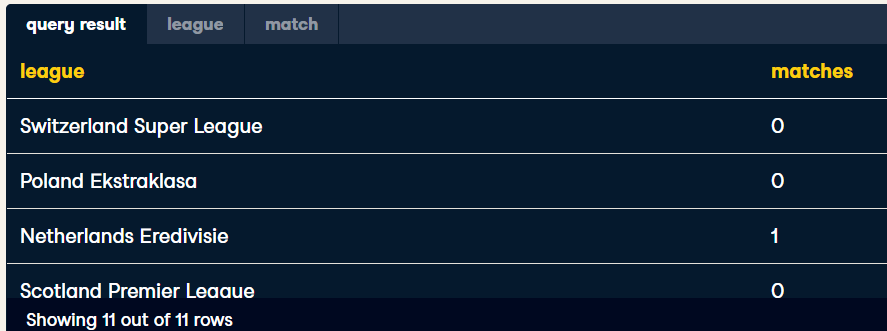


#### Organizing with CTEs

This time, let's expand on the exercise by looking at details about matches with very high scores using CTEs. Just like a subquery in FROM, you can join tables inside a CTE.

- Declare your CTE, where you create a list of all matches with the league name.
- Select the league, date, home, and away goals from the CTE.
- Filter the main query for matches with 10 or more goals.


```sql
-- Set up your CTE
WITH match_list AS (
  -- Select the league, date, home, and away goals
    SELECT 
  		l.name AS league, 
     	m.date, 
  		m.home_goal, 
  		m.away_goal,
       (m.home_goal + m.away_goal) AS total_goals
    FROM match AS m
    LEFT JOIN league as l ON m.country_id = l.id)
-- Select the league, date, home, and away goals from the CTE
SELECT league, date, home_goal, away_goal
FROM match_list
-- Filter by total goals
WHERE total_goals >= 10;
```
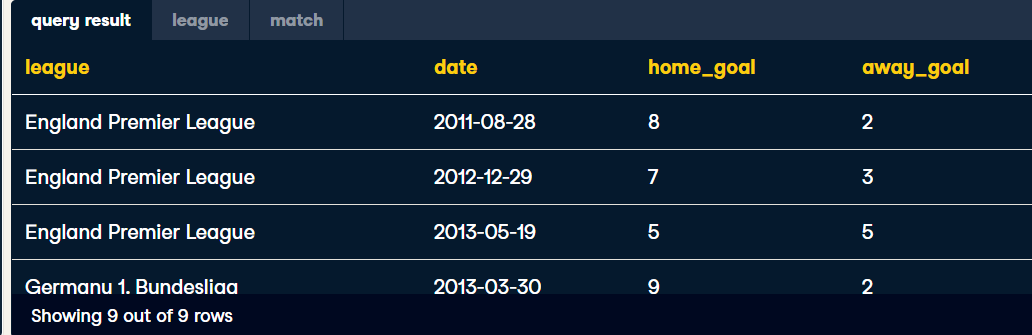

CTEs are much easier to read than multiple subqueries!

#### CTEs with nested subqueries
If you find yourself listing multiple subqueries in the FROM clause with nested statement, your query will likely become long, complex, and difficult to read.

Since many queries are written with the intention of being saved and re-run in the future, proper organization is key to a seamless workflow. Arranging subqueries as CTEs will save you time, space, and confusion in the long run!


- Declare a CTE that calculates the total goals from matches in August of the 2013/2014 season.
- Left join the CTE onto the league table using country_id from the match_list CTE.
- Filter the list on the inner subquery to only select matches in August of the 2013/2014 season.


```sql
-- Set up your CTE
WITH match_list AS (
    SELECT 
  		country_id, 
  	   (home_goal + away_goal) AS goals
    FROM match
    -- Create a list of match IDs to filter data in the CTE
    WHERE id IN (
       SELECT id
       FROM match
       WHERE season = '2013/2014' AND EXTRACT(MONTH FROM date) = 08))
-- Select the league name and average of goals in the CTE
SELECT
	l.name,
    AVG(match_list.goals)
FROM league AS l
-- Join the CTE onto the league table
LEFT JOIN match_list ON l.id = match_list.country_id
GROUP BY l.name;
```

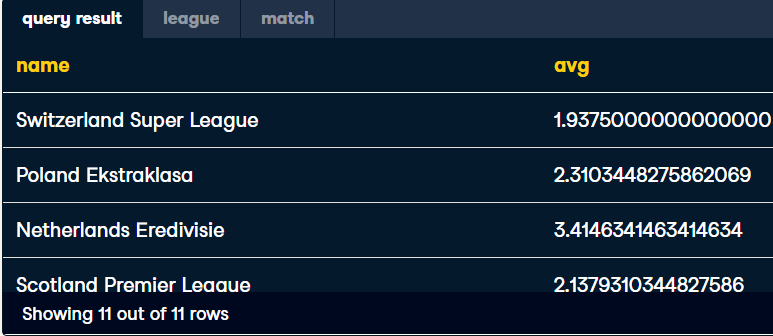

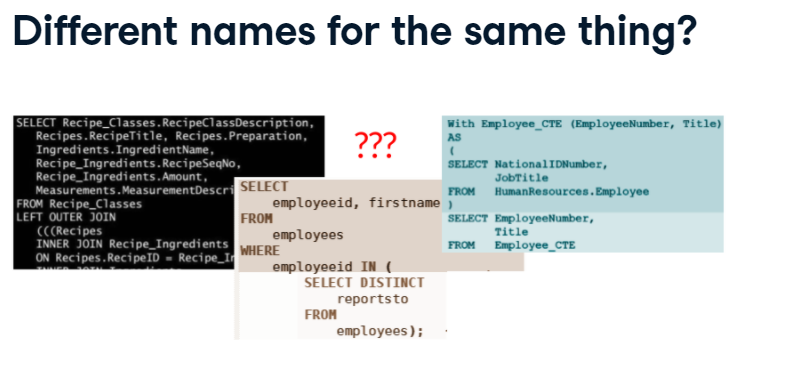

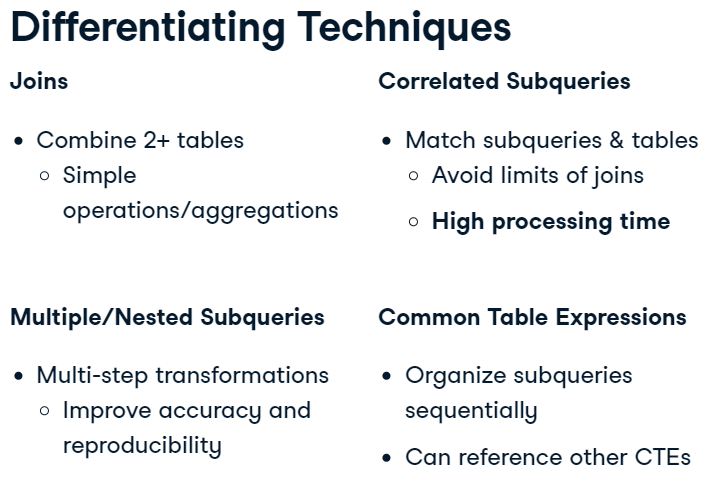

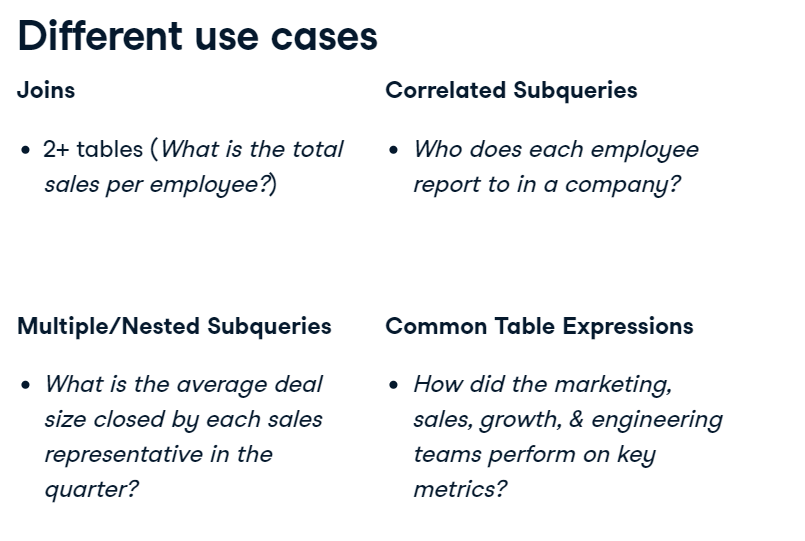


#### Get team names with a subquery
Let's solve a problem we've encountered a few times in this course so far -- How do you get both the home and away team names into one final query result?

Out of the 4 techniques we just discussed, this can be performed using subqueries, correlated subqueries, and CTEs. Let's practice creating similar result sets using each of these 3 methods over the next 3 exercises, starting with subqueries in FROM.

- Create a query that left joins team to match in order to get the identity of the home team. This becomes the subquery in the next step.

```sql
SELECT 
	m.id, 
    t.team_long_name AS hometeam
-- Left join team to match
FROM match AS m
LEFT JOIN team as t
ON m.hometeam_id = team_api_id;
```
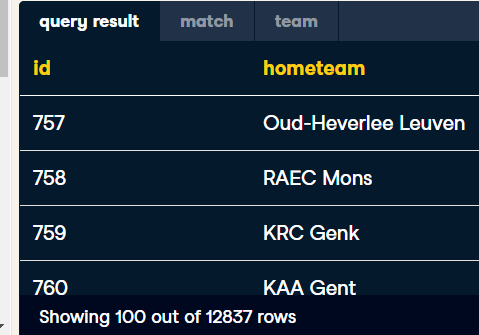

- Add a second subquery to the FROM statement to get the away team name, changing only the hometeam_id. Left join both subqueries to the match table on the id column.


**Warning: if your code is timing out, you have probably made a mistake in the JOIN and tried to join on the wrong fields which caused the table to be too big! Read the provided code and comments carefully, and check your ON conditions!**



```sql
SELECT
	m.date,
    -- Get the home and away team names
    hometeam,
    awayteam,
    m.home_goal,
    m.away_goal
FROM match AS m

-- Join the home subquery to the match table
LEFT JOIN (
  SELECT match.id, team.team_long_name AS hometeam
  FROM match
  LEFT JOIN team
  ON match.hometeam_id = team.team_api_id) AS home
ON home.id = m.id

-- Join the away subquery to the match table
LEFT JOIN (
  SELECT match.id, team.team_long_name AS awayteam
  FROM match
  LEFT JOIN team
  -- Get the away team ID in the subquery
  ON match.awayteam_id = team.team_api_id) AS away
ON away.id = m.id;
```

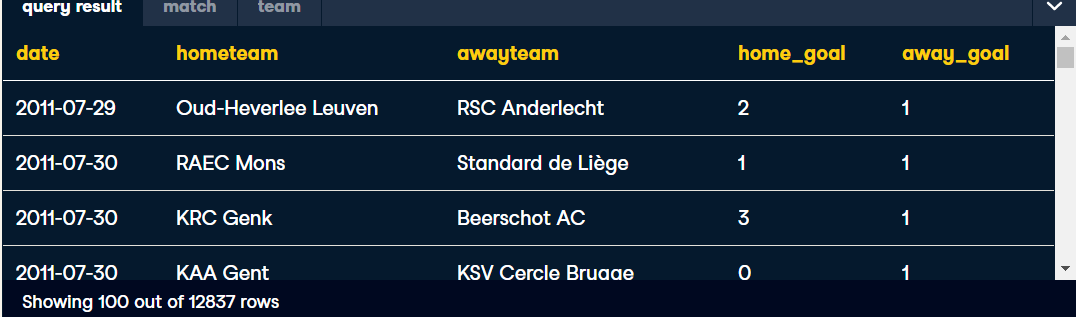
This is one clear way to generate a list of team names who played in a match. This is much easier to read than team ID numbers!


#### Get team names with correlated subqueries
Let's solve the same problem using correlated subqueries -- How do you get both the home and away team names into one final query result?

This can easily be performed using correlated subqueries. But how might that impact the performance of your query? Complete the following steps and let's find out!

Please note that your query will run more slowly than the previous exercise!


- Using a correlated subquery in the SELECT statement, match the team_api_id column from team to the hometeam_id from match.

```sql
SELECT
    m.date,
   (SELECT team_long_name
    FROM team AS t
    -- Connect the team to the match table
    WHERE t.team_api_id = m.hometeam_id) AS hometeam
FROM match AS m;
```

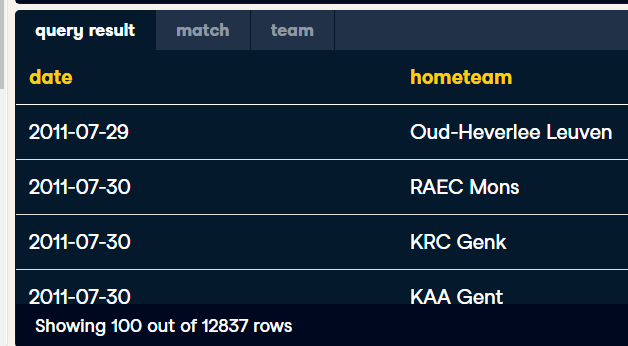

- Create a second correlated subquery in SELECT, yielding the away team's name.
- Select the home and away goal columns from match in the main query.

```sql
SELECT
    m.date,
   (SELECT team_long_name
    FROM team AS t
    WHERE t.team_api_id = m.hometeam_id) AS hometeam,
    -- Connect the team to the match table
   (SELECT team_long_name
    FROM team AS t
    WHERE t.team_api_id = m.awayteam_id) AS awayteam,
   -- Select home and away goals
    m.home_goal,
    m.away_goal
FROM match AS m;
```
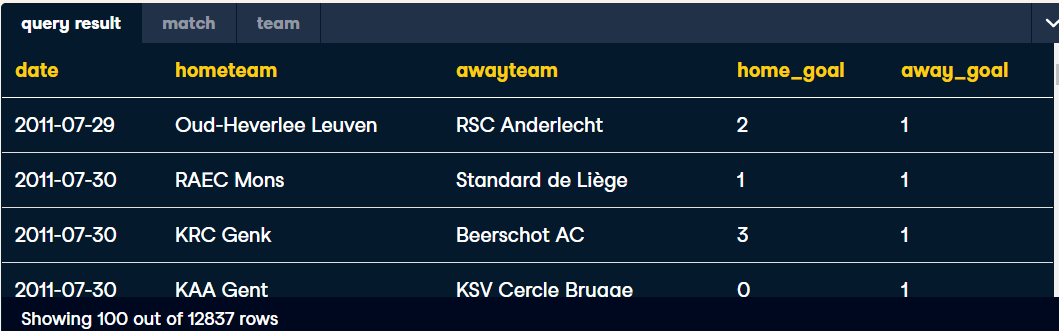

The syntax here is much simpler, but if you're working with a large data set your query may take a while to run!

#### Get team names with CTEs
You've now explored two methods for answering the question, How do you get both the home and away team names into one final query result?

Let's explore the final method - common table expressions. Common table expressions are similar to the subquery method for generating results, mainly differing in syntax and the order in which information is processed.


- Select id from match and team_long_name from team. Join these two tables together on hometeam_id in match and team_api_id in team.
```sql
SELECT 
	-- Select match id and team long name
    m.id, 
    t.team_long_name AS hometeam
FROM match AS m
-- Join team to match using team_api_id and hometeam_id
LEFT JOIN team AS t 
ON m.hometeam_id = t.team_api_id;
```
![image-18.png](attachment:image-18.png)

- Declare the query from the previous step as a common table expression. SELECT everything from the CTE into the main query. Your results will not change at this step!

```sql
-- Declare the home CTE
WITH home AS (
  SELECT m.id, t.team_long_name AS hometeam
  FROM match AS m
  LEFT JOIN team AS t 
  ON m.hometeam_id = t.team_api_id)
-- Select everything from home
SELECT *
FROM home;
```
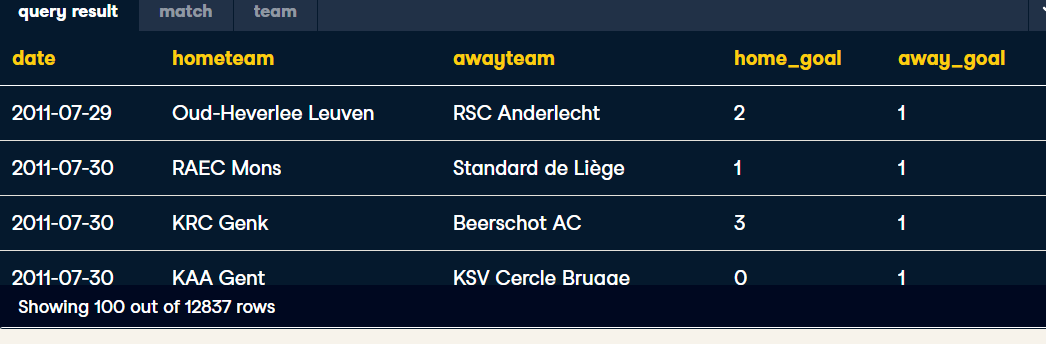

- Let's declare the second CTE, away. Join it to the first CTE on the id column.
- The date, home_goal, and away_goal columns have been added to the CTEs. SELECT them into the main query.

```sql
WITH home AS (
  SELECT m.id, m.date, 
  		 t.team_long_name AS hometeam, m.home_goal
  FROM match AS m
  LEFT JOIN team AS t 
  ON m.hometeam_id = t.team_api_id),
-- Declare and set up the away CTE
away AS (
  SELECT m.id, m.date, 
  		 t.team_long_name AS awayteam, m.away_goal
  FROM match AS m
  LEFT JOIN team AS t 
  ON m.awayteam_id = t.team_api_id)
-- Select date, home_goal, and away_goal
SELECT 
	home.date,
    home.hometeam,
    away.awayteam,
    home.home_goal,
    away.away_goal
-- Join away and home on the id column
FROM home
INNER JOIN away
ON home.id = away.id;
```
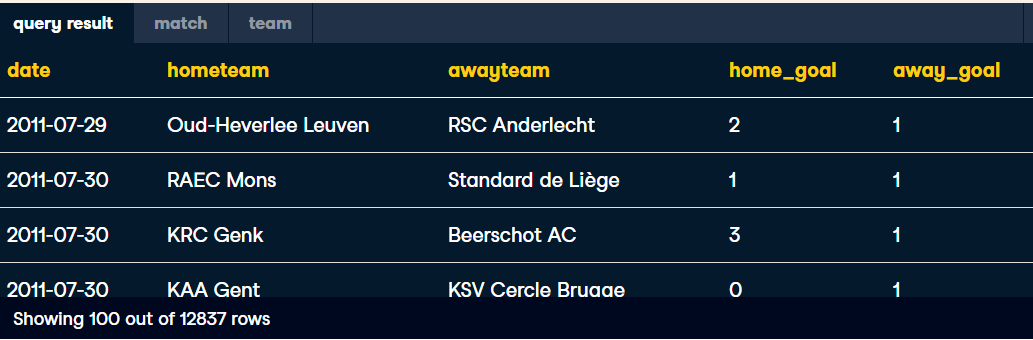

While correlated subqueries can reduce the length of your query, they also significantly increase query run time.